In [174]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import bambi
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy

## Fork 

- Common cause

In [32]:
#Fork Simulation 
N = 1000
Z = np.random.binomial(1,0.5,1000)
X = np.random.binomial(1, (1-Z)*0.1 + Z*0.9, N)
Y = np.random.binomial(1, (1-Z)*0.1 + Z*0.9, N)
# Overall correlation
np.corrcoef(X,Y)

array([[1.        , 0.62962622],
       [0.62962622, 1.        ]])

In [34]:
#No correlation at different levels of Z!
np.corrcoef(X[Z==0],Y[Z==0])

array([[1.        , 0.03858491],
       [0.03858491, 1.        ]])

In [36]:
np.corrcoef(X[Z==1],Y[Z==1])

array([[1.        , 0.04849996],
       [0.04849996, 1.        ]])

In [37]:
#Fork continuous example
N = 300
Z = np.random.binomial(1, 0.5,N)
X = np.random.normal(2*Z-1,size=N)
Y = np.random.normal(2*Z-1,size=N)

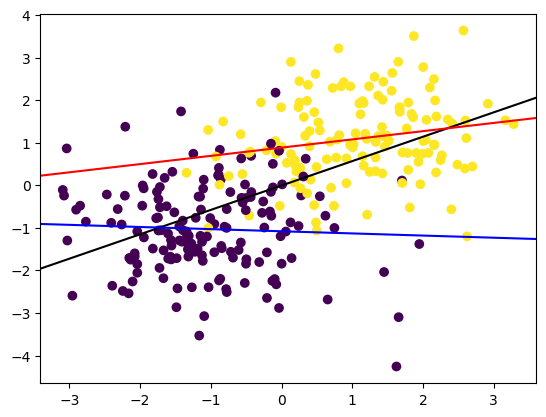

In [53]:
plt.scatter(X,Y,c=Z)

#Total Sample
m, b = np.polyfit(X, Y, deg=1) #Can also use stats.linregress(X,Y) or whatever else
plt.axline(xy1=(0, b), slope=m, c = 'black')

#Stratified by Z 
m0, b0 = np.polyfit(X[Z==0], Y[Z==0],deg=1)
plt.axline(xy1=(0,b0), slope=m0, c = 'blue')

m1, b1 = np.polyfit(X[Z==1], Y[Z==1],deg=1)
plt.axline(xy1=(0,b1), slope=m1, c='red')

Knowing X helps you predict Y unless you stratify by Z. Fork induces association, conditioning on the common cause removes the association.

## Waffle Divorce Example

Why do regions of the USA with higher rates of marriage also have higher rates of divorce?

Age at marriage is a fork, interested in it's influence on divorce. 

In [59]:
#Data
divorce = pd.read_csv('./Data/WaffleDivorce.csv',sep=';')
divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


<AxesSubplot: xlabel='Marriage', ylabel='Divorce'>

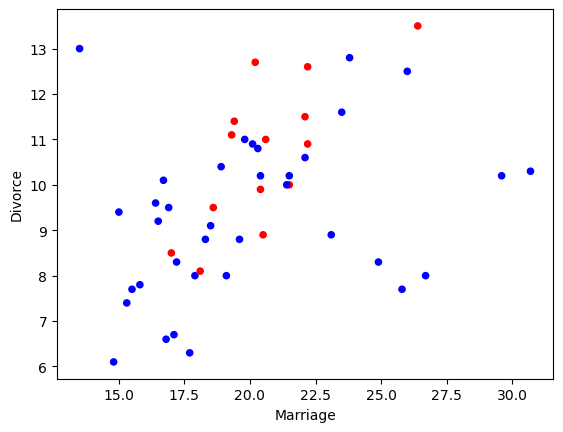

In [65]:
divorce.plot.scatter(x='Marriage',y='Divorce',c=divorce['South'].map({1:'red',0:'blue'}))

<AxesSubplot: xlabel='MedianAgeMarriage', ylabel='Divorce'>

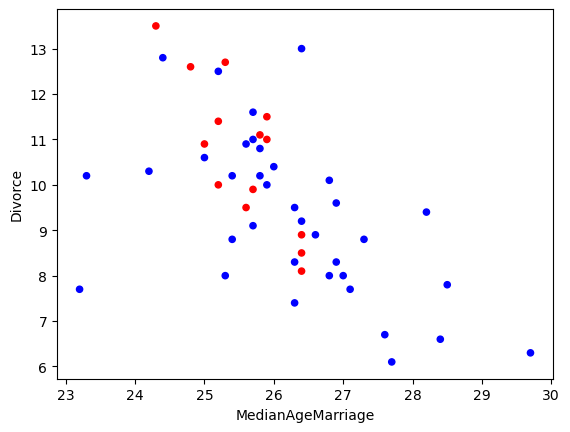

In [66]:
divorce.plot.scatter(x='MedianAgeMarriage',y='Divorce',c=divorce['South'].map({1:'red',0:'blue'}))

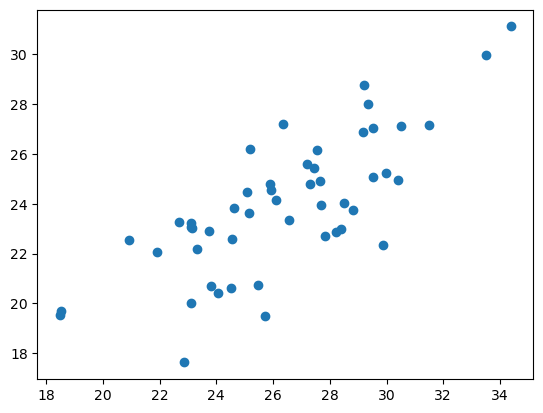

In [93]:
#Simulated Data
N = 50 #50 states
age_m = np.random.normal(20,1,N)
rate_m = np.random.normal(45 + (-0.9)* age_m,4,size=N)
rate_d = np.random.normal(0.6*rate_m + 0.4*age_m,2,size=N)
plt.scatter(x=rate_m,y=rate_d)

In [99]:
#standardizing
rate_m = scale(rate_m)
rate_d = scale(rate_d)
age_m = scale(age_m)

In [102]:
# Every value of A produces a different relationship between
# D and M

with pm.Model() as m_sim_model:
    bM = pm.Normal('bM',0,0.5)
    bA = pm.Normal('bA',0,0.5)
    
    a = pm.Normal('a',0,.2)
    sigma = pm.Exponential('sigma',5)
    #mu = a + bM[rate_m]*rate_m + bA[age_M]*age_M
    mu = a + bM*rate_m + bA*age_m
    
    D =  pm.Normal('D',mu,sigma,observed= rate_d)
    m_sim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
G:\Statistical_Rethinking\rethinking\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [103]:
az.summary(m_sim_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,0.735,0.097,0.551,0.909,0.001,0.001,5242.0,3319.0,1.0
bA,0.016,0.095,-0.160,0.194,0.001,0.001,4659.0,3054.0,1.0
a,-0.000,0.083,-0.158,0.155,0.001,0.001,5284.0,3154.0,1.0
sigma,0.665,0.065,0.553,0.792,0.001,0.001,4299.0,3130.0,1.0


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

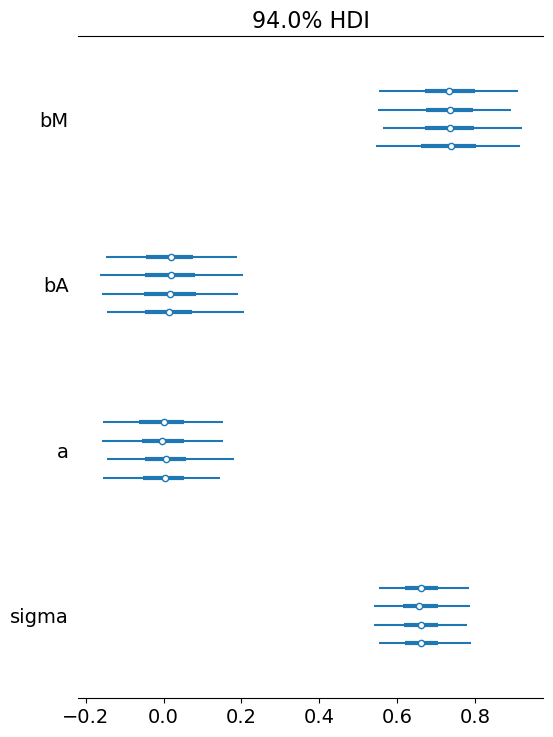

In [105]:
az.plot_forest(m_sim_trace)

In [112]:
##Actual data
A = scale(divorce['MedianAgeMarriage'])
D = scale(divorce['Divorce'])
M = scale(divorce['Marriage'])

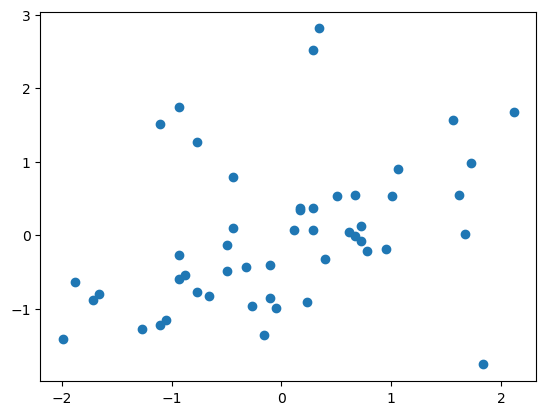

In [113]:
plt.scatter(D,M)

In [114]:
with pm.Model() as m_model:
    bM = pm.Normal('bM',0,0.5)
    bA = pm.Normal('bA',0,0.5)
    
    a = pm.Normal('a',0,.2)
    sigma = pm.Exponential('sigma',5)
    #mu = a + bM[rate_m]*rate_m + bA[age_M]*age_M
    mu = a + bM*M + bA*A
    
    D =  pm.Normal('D',mu,sigma,observed= D)
    m_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bM, bA, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

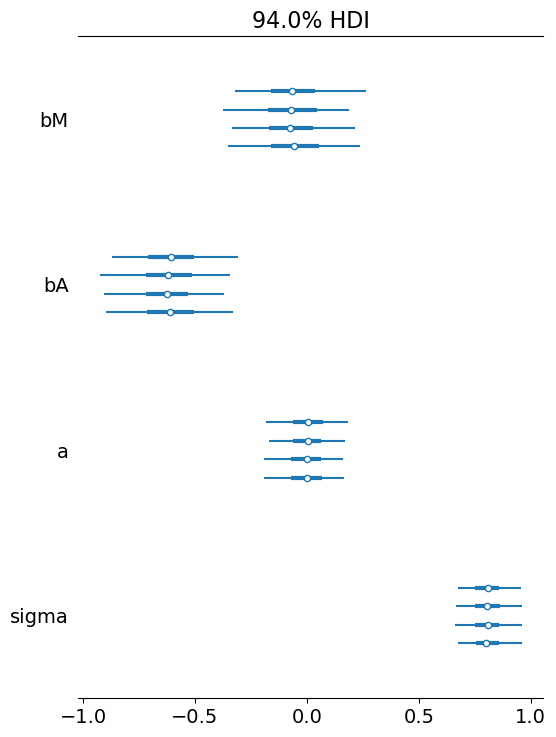

In [115]:
az.plot_forest(m_trace)

In [116]:
az.summary(m_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.065,0.154,-0.351,0.225,0.003,0.002,2893.0,2913.0,1.0
bA,-0.613,0.153,-0.903,-0.336,0.003,0.002,3038.0,2855.0,1.0
a,-0.000,0.096,-0.189,0.169,0.002,0.002,3616.0,2079.0,1.0
sigma,0.808,0.079,0.672,0.964,0.001,0.001,3472.0,2733.0,1.0


## Simulating interventions
Delete arrows into M 
Set multiple values of M, keep A fixed. Measure the dfferences it makes

In [119]:
with m_model:
    m_trace.extend(pm.sample_posterior_predictive(m_trace))

Sampling: [D]


In [125]:
m_trace.posterior['a']

<xarray.DataArray 'a' (chain: 4, draw: 1000)>
array([[-0.10204931,  0.11823348, -0.1005232 , ...,  0.13790788,
        -0.12797987, -0.10722017],
       [ 0.01555088,  0.04593115,  0.05677738, ...,  0.01791153,
         0.0865376 , -0.03634526],
       [-0.01079123, -0.00019964, -0.00019964, ..., -0.18061421,
        -0.13793599, -0.00566398],
       [-0.13094155,  0.05471371,  0.02894776, ...,  0.06851682,
        -0.06548322,  0.06075209]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [131]:
As = np.random.choice(A,size = (4,1000), replace = True)
As.shape

(4, 1000)

In [134]:
post = m_trace.posterior
post

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    bM       (chain, draw) float64 0.003519 -0.2149 ... -0.08738 -0.1735
    bA       (chain, draw) float64 -0.4725 -0.6941 -0.7138 ... -0.4007 -0.4655
    a        (chain, draw) float64 -0.102 0.1182 -0.1005 ... -0.06548 0.06075
    sigma    (chain, draw) float64 0.8575 0.7663 0.7648 ... 0.6985 0.8278 0.7878
Attributes:
    created_at:                 2023-01-17T05:34:58.483609
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.1
    sampling_time:              14.469027996063232
    tuning_steps:               1000

In [139]:
DM0 = np.random.normal(post['a'] + post['bM']*0 + post['bA']*As, post['sigma'])
DM1 = np.random.normal(post['a'] + post['bM']*1 + post['bA']*As, post['sigma'])

Text(0.5, 1.0, 'DM Contrast')

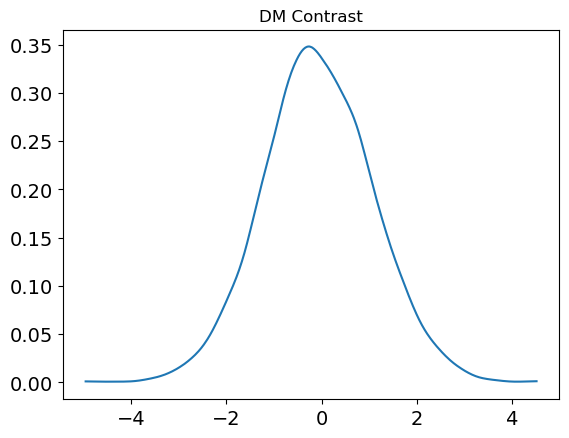

In [145]:
#The posterior distribution of the contrast. The posterior distribution of the causal effect of increasing
#M by one standard deviation. 
DM_contrast = DM1 - DM0
az.plot_kde(DM_contrast)
plt.title('DM Contrast')

  ## Causal effect of A
  
  All you need to do is fit a new model that ignores M, then simulate any intervention. 
  
  A -> M -> is a pipe 

## Pipe Generative Simulation

Proving that Y will be independent of X, if we condition on Z (the mediator in the middle of the pipe)

Everything that Y 'knows' about X is known by Z. So once you learn Z, theres nothing more to learn about the association


In [163]:
n = 1000 
X = np.random.binomial(1,0.5,n)
Z = np.random.binomial(1,(1-X)*0.1 + X*0.9,n)
Y = np.random.binomial(1,(1-Z)*0.1 + Z*0.9,n)
np.corrcoef(X,Y)

array([[1.       , 0.6638911],
       [0.6638911, 1.       ]])

In [164]:
np.corrcoef(X[Z==0],Y[Z==0])

array([[ 1.        , -0.02549576],
       [-0.02549576,  1.        ]])

In [165]:
np.corrcoef(X[Z==1],Y[Z==1])

array([[1.        , 0.04021719],
       [0.04021719, 1.        ]])

### Post Treatment Bias

Take care when stratifying. 

Consequences of treatment should not usually be included in estimator.

Draw the causal assumptions

## The Collider Generative Simulation

X & Y are not associated

X & Y both influence Z

Once stratified by Z, X and Y associate

In [170]:
N = 1000
X = np.random.binomial(1,0.5,N)
Y = np.random.binomial(1,0.5,N)
Z = np.random.binomial(1,[0.9 if x > 0 else 0.2 for x in (X+Y)])
np.corrcoef(X,Y)

array([[1.        , 0.03310508],
       [0.03310508, 1.        ]])

In [171]:
np.corrcoef(X[Z==0],Y[Z==0])

array([[1.        , 0.43842903],
       [0.43842903, 1.        ]])

In [172]:
np.corrcoef(X[Z==1],Y[Z==1])

array([[ 1.        , -0.33395621],
       [-0.33395621,  1.        ]])

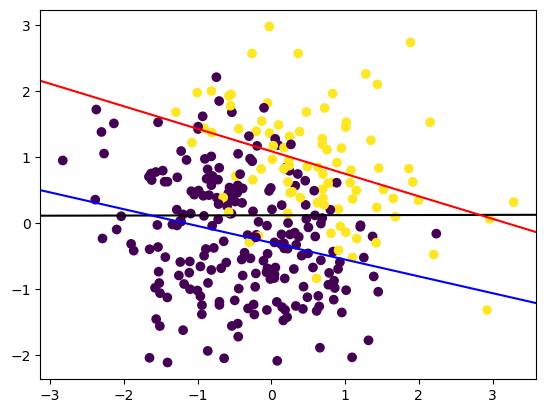

In [180]:
N = 300
X = np.random.normal(size=N)
Y = np.random.normal(size=N)
Z = np.random.binomial(1,scipy.special.expit(2*X+2*Y-2)) #expit is inverse logit 

plt.scatter(X,Y,c=Z)

#Total Sample
m, b = np.polyfit(X, Y, deg=1) #Can also use stats.linregress(X,Y) or whatever else
plt.axline(xy1=(0, b), slope=m, c = 'black')

#Stratified by Z 
m0, b0 = np.polyfit(X[Z==0], Y[Z==0],deg=1)
plt.axline(xy1=(0,b0), slope=m0, c = 'blue')

m1, b1 = np.polyfit(X[Z==1], Y[Z==1],deg=1)
plt.axline(xy1=(0,b1), slope=m1, c='red')

## Descendent

If the descendent is included in the model, it is like weakly including the parent

Stratifying by the descendent will be like weakly stratifying by the parent. 
